# Multiscale Lorenz Examples

In [1]:
import sys
import os.path as op
import math
sys.path.insert(0, op.abspath('..'))

import numpy as np
import scipy as sp
from scipy import stats, linalg

import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import proj3d

import vlgp
from vlgp import util, hyper
from vlgp import simulation as sim

In [2]:
def lorenz(n, dt=0.01, s=10, r=28, b=8/3, x0=(0.0, 1.0, 1.05)):
    """Lorenz system
    dx/dt = s*(y - x)
    dy/dt = x*(r - z) - y
    dz/dt = x*y - b*z
    """
    from numpy import empty, inf
    from numpy.linalg import norm

    def dlorenz(x, y, z):
        x_dot = s * (y - x)
        y_dot = x * (r - z) - y
        z_dot = x * y - b * z
        return x_dot, y_dot, z_dot

    xs = empty((n, 3), dtype=float)
    xs[0, :] = x0
    
    # Euler intergration
    for i in range(n - 1):
        dx, dy, dz = dlorenz(xs[i, 0], xs[i, 1], xs[i, 2])
        xs[i + 1, 0] = xs[i, 0] + dx * dt
        xs[i + 1, 1] = xs[i, 1] + dy * dt
        xs[i + 1, 2] = xs[i, 2] + dz * dt

    return xs

We used the standard Lorenz system, $\sigma = 10$, $\rho = 28$ and $\beta = 10/3$. To show vLGP works for various latent dynamics, we use 3 different sampling rate $\Delta t$, a moderate one (0.006), a slow one (0.001) and a fast one (0.01).

Here we only simulated spike trains of 30 neurons under one condition (random initial state). The synthetic dataset consist of 20 trials per condition. We fix each trial as 1 sec and the time binwidth is 1 ms.

In [3]:
ntrial = 20  # number of trials
obs_ndim = 30  # number of neurons (spike trains)
dyn_ndim = 3  # latent dimensions
binwidth = 1  # in ms 
tau = 100 # in ms
nbin = 1000 # 1s

We use the same random weights and 5 spike/s baseline firing rate for all the data.

In [ ]:
np.random.seed(1)
bias = np.log(5 / nbin)  # log base firing rate
a = 5 * ((np.random.rand(dyn_ndim, obs_ndim) + 1) * np.sign(np.random.randn(dyn_ndim, obs_ndim))) # loading matrix
b = np.vstack((bias * np.ones(obs_ndim)))

We keep everything the same except the $\Delta t$ when generating different latent dynamics. 
**We use the same inference options for all three types of dynamics.**

## Moderate Speed Lorenz Dynamics

In [24]:
dt = 0.006
t = 100
n = math.ceil(t / dt)
np.random.seed(0)
x0 = np.random.randn(3)
x = lorenz(n * 2, dt, s=10, r=28, b=8/3, x0=x0)
xs = np.array_split(x[n:, :], t // 4, axis=0)
i = 200 * 19 + 100
x_k = x[i : i + nbin, :]
x_k = x_k - x_k.mean(axis=0)
x_k /= linalg.norm(x_k, axis=0, ord=np.inf)

dyn = np.tile(x_k, (ntrial, 1, 1))

We plot the three dimensions separately and together.

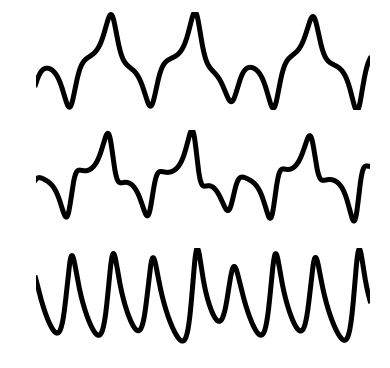

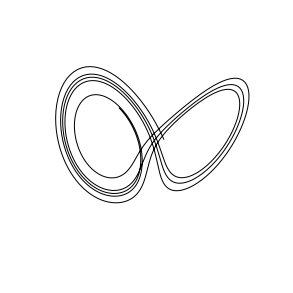

In [25]:
plt.figure(figsize=(6, 6))
ax1 = plt.subplot(311)
ax1.plot(x_k[:, 0], lw=5, color='k')
ax1.set_axis_off()

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(x_k[:, 1], lw=5, color='k')
ax2.set_axis_off()

ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(x_k[:, 2], lw=5, color='k')
ax3.set_axis_off()

plt.figure(figsize=(5, 5))
ax = plt.gca(projection='3d')
ax.plot(*x_k.T, color='k')
ax.set_axis_off()

In [11]:
y = np.stack([sim.spike(dyn[i, ...], a, b)[0] for i in range(ntrial)]).squeeze()

The following is one trial of spike trains. We did not sort the neurons.

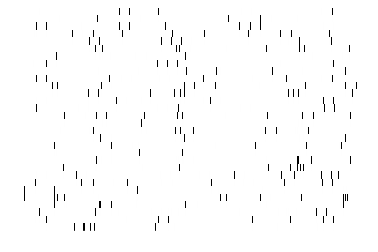

In [12]:
plt.imshow(y[0, ...].T, vmin=0, vmax=1, interpolation='none', aspect='auto', cmap=plt.cm.Greys);
plt.gca().set_axis_off()

In [ ]:
np.random.seed(0)
mod_fit, _ = vlgp.fit(y, ['spike']*y.shape[-1], 
                     dyn_ndim=3,
                     sigma=np.ones(dyn_ndim) * (1 - 1e-3), 
                     omega=np.ones(dyn_ndim)*(2*(binwidth/tau)**2),
                     lag=0, rank=500, 
                     x=dyn, alpha=a, beta=b,  
                     method='VB',  
                     niter=100, tol=1e-5, verbose=False, 
                     learn_param=True, learn_post=True, e_niter=5, m_niter=5, adjust_hessian=False, decay=0,Adam=False,
                     learn_hyper=True, nhyper=5, subsample_size=200, hyper_obj='ELBO', 
                     gp_noise=1e-3, successive=False)
util.save(mod_fit, 'mod_fit.h5')

We plot one trial of the true (black) and inferred (red) trajectory.  

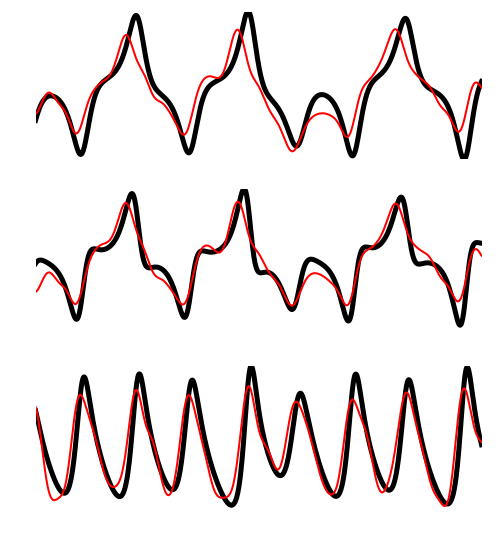

In [14]:
x_hat = util.rotate(util.add_constant(mod_fit['mu'][0, ...]), mod_fit['x'][0, ...])

plt.figure(figsize=(8, 9))
ax1 = plt.subplot(311)
ax1.plot(mod_fit['x'][0, :, 0], lw=5, color='k')
ax1.plot(x_hat[:, 0], lw=2, color='r')
ax1.set_axis_off()

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(mod_fit['x'][0, :, 1], lw=5, color='k')
ax2.plot(x_hat[:, 1], lw=2, color='r')
ax2.set_axis_off()

ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(mod_fit['x'][0, :, 2], lw=5, color='k')
ax3.plot(x_hat[:, 2], lw=2, color='r')
ax3.set_axis_off()

## Slow Lorenz Dynamics

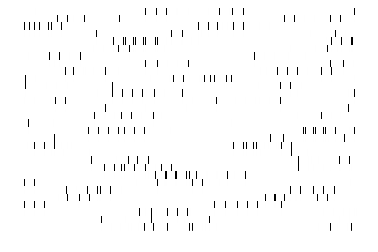

In [15]:
dt = 0.001
t = 100
n = math.ceil(t / dt)
np.random.seed(0)
x0 = np.random.randn(3)
x = lorenz(n * 2, dt, s=10, r=28, b=8/3, x0=x0)
xs = np.array_split(x[n:, :], t // 4, axis=0)
i = 200 * 19 + 100
x_k = x[i : i + nbin, :]
x_k = x_k - x_k.mean(axis=0)
x_k /= linalg.norm(x_k, axis=0, ord=np.inf)

dyn = np.tile(x_k, (ntrial, 1, 1))
nbin = dyn.shape[1]

y = np.stack([sim.spike(dyn[i, ...], a, b)[0] for i in range(ntrial)]).squeeze()
plt.imshow(y[0, ...].T, vmin=0, vmax=1, interpolation='none', aspect='auto', cmap=plt.cm.Greys);
plt.gca().set_axis_off()

In [ ]:
np.random.seed(0)
slow_fit, _ = vlgp.fit(y, ['spike']*y.shape[-1], 
                     dyn_ndim=3,
                     sigma=np.ones(dyn_ndim) * (1 - 1e-3), 
                     omega=np.ones(dyn_ndim)*(2*(binwidth/tau)**2),
                     lag=0, rank=500, 
                     x=dyn, alpha=a, beta=b,  
                     method='VB',  
                     niter=100, tol=1e-5, verbose=False, 
                     learn_param=True, learn_post=True, e_niter=5, m_niter=5, adjust_hessian=False, decay=0,Adam=False,
                     learn_hyper=True, nhyper=5, subsample_size=200, hyper_obj='ELBO', 
                     gp_noise=1e-3, successive=False)
util.save(slow_fit, 'slow_fit.h5')

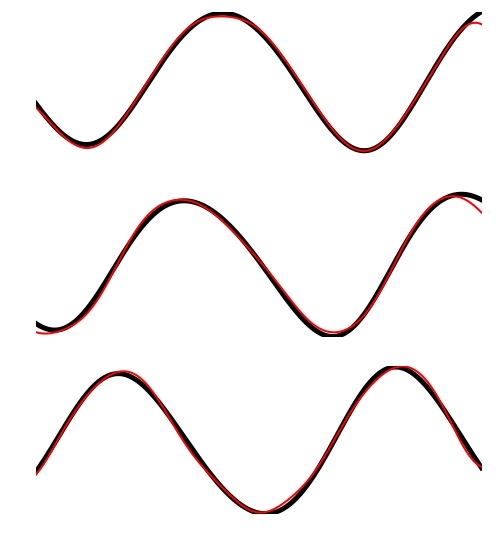

In [18]:
x_hat = util.rotate(util.add_constant(slow_fit['mu'][0, ...]), slow_fit['x'][0, ...])

plt.figure(figsize=(8, 9))
ax1 = plt.subplot(311)
ax1.plot(slow_fit['x'][0, :, 0], lw=5, color='k')
ax1.plot(x_hat[:, 0], lw=2, color='r')
ax1.set_axis_off()

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(slow_fit['x'][0, :, 1], lw=5, color='k')
ax2.plot(x_hat[:, 1], lw=2, color='r')
ax2.set_axis_off()

ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(slow_fit['x'][0, :, 2], lw=5, color='k')
ax3.plot(x_hat[:, 2], lw=2, color='r')
ax3.set_axis_off()

## Fast Lorenz Dynamics

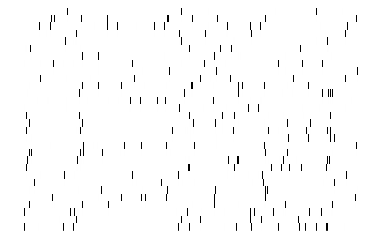

In [19]:
dt = 0.01
t = 100
n = math.ceil(t / dt)
np.random.seed(0)
x0 = np.random.randn(3)
x = lorenz(n * 2, dt, s=10, r=28, b=8/3, x0=x0)
xs = np.array_split(x[n:, :], t // 4, axis=0)
i = 200 * 19 + 100
x_k = x[i : i + nbin, :]
x_k = x_k - x_k.mean(axis=0)
x_k /= linalg.norm(x_k, axis=0, ord=np.inf)

dyn = np.tile(x_k, (ntrial, 1, 1))
nbin = dyn.shape[1]

y = np.stack([sim.spike(dyn[i, ...], a, b)[0] for i in range(ntrial)]).squeeze()
plt.imshow(y[0, ...].T, vmin=0, vmax=1, interpolation='none', aspect='auto', cmap=plt.cm.Greys);
plt.gca().set_axis_off()

In [ ]:
np.random.seed(0)
fast_fit, _ = vlgp.fit(y, ['spike']*y.shape[-1], 
                     dyn_ndim=3,
                     sigma=np.ones(dyn_ndim) * (1 - 1e-3), 
                     omega=np.ones(dyn_ndim)*(2*(binwidth/tau)**2),
                     lag=0, rank=500, 
                     x=dyn, alpha=a, beta=b,  
                     method='VB',  
                     niter=100, tol=1e-5, verbose=False, 
                     learn_param=True, learn_post=True, e_niter=5, m_niter=5, adjust_hessian=False, decay=0,Adam=False,
                     learn_hyper=True, nhyper=5, subsample_size=200, hyper_obj='ELBO', 
                     gp_noise=1e-3, successive=False)
util.save(fast_fit, 'fast_fit.h5')

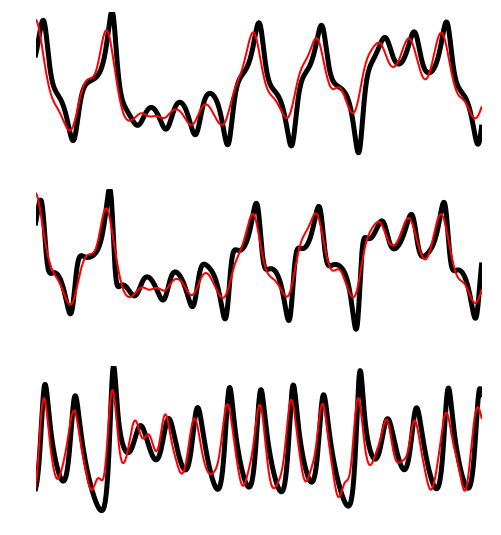

In [22]:
x_hat = util.rotate(util.add_constant(fast_fit['mu'][0, ...]), fast_fit['x'][0, ...])

plt.figure(figsize=(8, 9))
ax1 = plt.subplot(311)
ax1.plot(fast_fit['x'][0, :, 0], lw=5, color='k')
ax1.plot(x_hat[:, 0], lw=2, color='r')
ax1.set_axis_off()

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(fast_fit['x'][0, :, 1], lw=5, color='k')
ax2.plot(x_hat[:, 1], lw=2, color='r')
ax2.set_axis_off()

ax3 = plt.subplot(313, sharex=ax1)
ax3.plot(fast_fit['x'][0, :, 2], lw=5, color='k')
ax3.plot(x_hat[:, 2], lw=2, color='r')
ax3.set_axis_off()